In [1]:
import fitsio as ft
import healpy as hp
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# read imaging
dt = pd.read_hdf('/home/mehdi/data/templates/dr8pixweight-0.32.0_combined256.h5')
dr8_cols = ['ebv', 'loghi', 'nstar',
            'depth_r_total', 'depth_g_total', 'depth_z_total',
             'fwhm_r_mean', 'fwhm_g_mean', 'fwhm_z_mean',
            'airmass_r_mean', 'airmass_g_mean', 'airmass_z_mean',
            'ccdskymag_r_mean', 'ccdskymag_g_mean', 'ccdskymag_z_mean',
             'exptime_r_total', 'exptime_g_total', 'exptime_z_total',
             'mjd_r_min', 'mjd_g_min', 'mjd_z_min', 
            'galdepth_g','galdepth_r', 'galdepth_z', 
            'psfsize_g', 'psfsize_r', 'psfsize_z']
features = dt[dr8_cols].values

In [3]:
# read data and randoms
ngal = hp.read_map('/home/mehdi/data/tanveer/elg_gal256.fits', verbose=False, dtype=np.float64)
nran = hp.read_map('/home/mehdi/data/tanveer/elg_ran256.fits', verbose=False, dtype=np.float64)
frac = nran / nran[nran > 0].mean()

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


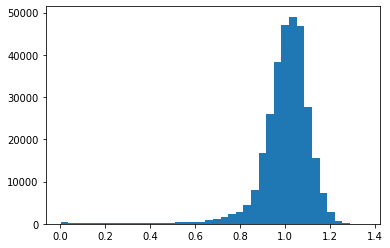

In [4]:
_ = plt.hist(frac[nran>0], bins=40)

In [7]:
mask = frac > 0.2
npix = mask.sum()
nsys = features.shape[1]
print(f'npix: {npix}, nsys: {nsys}')
isgood = np.isfinite(features).sum(axis=1) == nsys
mask = mask & isgood
npix = mask.sum()
print(f'npix: {npix}, nsys: {nsys}')

npix: 302795, nsys: 27
npix: 302503, nsys: 27


In [8]:
data = np.zeros(npix, dtype=[('label', 'f8'),
                             ('features', 'f8', nsys),
                             ('hpix', 'i8'),
                             ('fracgood', 'f8')])

data['label'] = ngal[mask]
data['fracgood'] = frac[mask]
data['features'] = features[mask, :]
data['hpix'] = np.argwhere(mask).flatten()

In [10]:
for ni in data.dtype.names:
    print((~np.isfinite(data[ni])).sum(), ni)

0 label
0 features
0 hpix
0 fracgood


In [12]:
ft.write('/home/mehdi/data/tanveer/dr8_elg_0.32.0_256.fits', data, clobber=True)

In [11]:
for i in range(data['features'].shape[1]):
    print(np.std(data['features'][:, i]), i)

0.0324522365999097 0
0.24676607647539517 1
550.9678470423167 2
0.5453596961046706 3
0.460072950968793 4
0.3398449458209416 5
0.4861657472377818 6
0.4330989076953627 7
0.2951514697330035 8
0.2735265257649082 9
0.2676904587698299 10
0.29974618479927223 11
0.5325523954193835 12
0.44819525802087906 13
0.32808173722527234 14
9030.468845016689 15
10422.278171963622 16
19097.314448930163 17
548.7131457853025 18
505.768741111331 19
475.1770182805158 20
0.26292189723357745 21
0.3651981766127112 22
0.1942551042540837 23
0.26579899443464733 24
0.2388452860229008 25
0.17912486892118784 26


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import healpy as hp
import fitsio as ft

import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
from lssutils.utils import hpixsum, make_overdensity, hpix2radec
from lssutils.stats.cl import AnaFast
from lssutils.stats.nnbar import MeanDensity

In [2]:
class GenSys:
    def __init__(self):        
        self.npred_ = ft.read('/home/mehdi/data/tanveer/elg_mse/nn-weights.fits')
        self.mask_ = np.zeros(12*256*256, '?')
        self.mask_[self.npred_['hpix']] = True

    def __call__(self, ix, dat, ran, mask):
        
        npred = np.zeros_like(dat)
        wnn_ix = self.npred_['weight'][:, ix]
        wnn_ix = wnn_ix / wnn_ix.mean()
        wnn_ix = wnn_ix.clip(0.5, 2.0)
        
        npred[self.npred_['hpix']] = wnn_ix

        mask_comm = mask & self.mask_
        norm_fact = dat[mask_comm].sum()/(dat[mask_comm]*npred[mask_comm]).sum()
        
        dat_cont = dat.copy()
        dat_cont[mask_comm] *= npred[mask_comm]*norm_fact

        delta_cont = make_overdensity(dat_cont, ran, mask)
        return delta_cont        

In [3]:
dat_ = ft.read('/home/mehdi/data/tanveer/FA_EZmock_desi_ELG_v0_10.fits')

dat = hpixsum(256, dat_['RA'], dat_['DEC'])*1.0
ran = hp.read_map('/home/mehdi/data/tanveer/FA_EZmock_desi_ELG_v0_rand_00to2.hp256.fits', 
                  verbose=False, dtype=np.float64)*1.0
mask = ran > 0

delta_clean = make_overdensity(dat, ran, mask) # clean delta

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [4]:
gensys = GenSys()
af = AnaFast()

results = {}

results['before'] = af(delta_clean, ran, mask)
for ix in range(25):
    delta_ix = gensys(ix, dat, ran, mask)
    results[f'after_{ix}'] = af(delta_ix, ran, mask)
    print('.', end='')

.........................

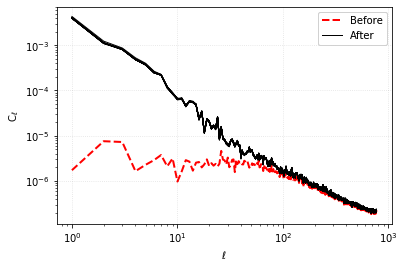

In [16]:
fig, ax = plt.subplots()


for ni, cli in results.items():
    ls = 'k-' if 'after' in ni else 'r--'
    lw = 2.0 if ni=='before' else 1.0
    
    ax.plot(cli['l'][1:], cli['cl'][1:], ls, lw=lw)    
    
lines = ax.get_lines()
lgnd = plt.legend(lines[:2], ['Before', 'After'])
fig.add_artist(lgnd)

ax.set(xscale='log', yscale='log', ylabel=r'C$_{\ell}$', xlabel=r'$\ell$')
ax.grid(True, ls=':', alpha=0.4)
fig.savefig('cl_before_after.png', dpi=300, bbox_inches='tight')

In [6]:
from lssutils.dataviz import mollview, mycolor

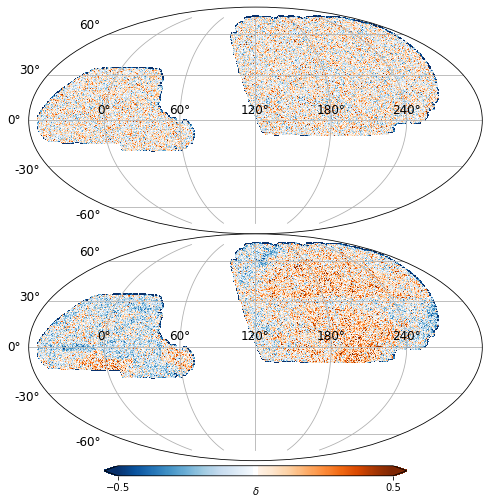

In [15]:
unit = r'$\delta$'
vmin = -0.5
vmax = 0.5

fig = plt.figure(figsize=(7, 7))
# matplotlib is doing the mollveide projection
ax  = fig.add_subplot(211, projection='mollweide')
ax1 = fig.add_subplot(212, projection='mollweide')
spacing = 0.05
plt.subplots_adjust(bottom=spacing, top=1-spacing, 
                    left=spacing, right=1-spacing,
                    hspace=0.0, wspace=0.0)


mollview(delta_clean, vmin, vmax, unit, figax=[fig, ax], cmap=mycolor())
mollview(delta_ix, vmin, vmax, unit, figax=[fig, ax1], cmap=mycolor(), colorbar=True)
fig.savefig('delta_before_after.png', dpi=300, bbox_inches='tight')

In [1]:
# Simulate systematics in the mocks

import numpy as np
import healpy as hp
import fitsio as ft

import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
sys.path.insert(0, '/home/mehdi/github/sysnetdev')

from sysnet.sources.train import evaluate
from sysnet.sources.models import DNN
from sysnet.sources.losses import init_loss
from sysnet.sources.io import load_checkpoint, ImagingData, MyDataSet, DataLoader

from lssutils.utils import hpixsum, make_overdensity, hpix2radec
from lssutils.stats.cl import AnaFast
from lssutils.stats.nnbar import MeanDensity

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
from lssutils.utils import DR9Data

In [4]:
dr9 = DR9Data('/home/mehdi/data/formehdi/pixweight_ar-dr8-0.32.0-elg-colorbox.fits')

In [5]:
columns = ['STARDENS', 'EBV', 
           'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 
                      'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 
                      'PSFDEPTH_W1', 'PSFDEPTH_W2',
                      'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']
dr9.dt[columns]

array([(1296.3281, -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.),
       (1220.0736, -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.),
       (1448.8374, -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.),
       ...,
       (2097.0015, -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.),
       (1963.5559, -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.),
       (1620.4103, -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.)],
      dtype={'names':['STARDENS','EBV','PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','PSFDEPTH_W1','PSFDEPTH_W2','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z'], 'formats':['>f4','>f4','>f4','>f4','>f4','>f4','>f4','>f4','>f4','>f4','>f4','>f4','>f4'], 'offsets':[56,52,8,12,16,20,24,28,32,36,40,44,48], 'itemsize':151})

In [4]:
# delta_clean = np.load('/home/mehdi/data/tanveer/elg_delta1024.npy')
# random_hp = np.load('/home/mehdi/data/tanveer/elg_ran1024.npy')
# mask = ran > 0.0

# EZmock DESI
mock = ft.read('/home/mehdi/data/fortanveer/FA_EZmock_desi_ELG_v0_10.fits')
mock_hp = hpixsum(256, mock['RA'], mock['DEC'])*1.0
random_hp = hp.read_map('/home/mehdi/data/mocksys/FA_EZmock_desi_ELG_v0_rand_00to2.hp256.fits')
mask_hp = random_hp > 0.0

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [5]:
wnn = hp.read_map('/home/mehdi/data/formehdi/0.4/nn-weights-ccd-v0.4hp256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [6]:
mask = mask_hp & np.isfinite(wnn)

In [7]:
delta_clean = make_overdensity(mock_hp, random_hp, mask)
delta_cont = make_overdensity(mock_hp*wnn, random_hp, mask)

In [8]:
af = AnaFast()
results = {}
results['before'] = af(delta_clean, mask*1.0, mask)
results['after'] = af(delta_cont, mask*1.0, mask)

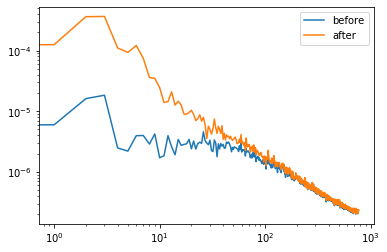

In [9]:
for ni, resi in results.items():
    plt.plot(resi['cl'], label=ni)
    
plt.xscale('log')
plt.legend()
plt.yscale('log')
# plt.xlim(xmin=10)
# plt.ylim(1.0e-7, 1.0e-4)

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


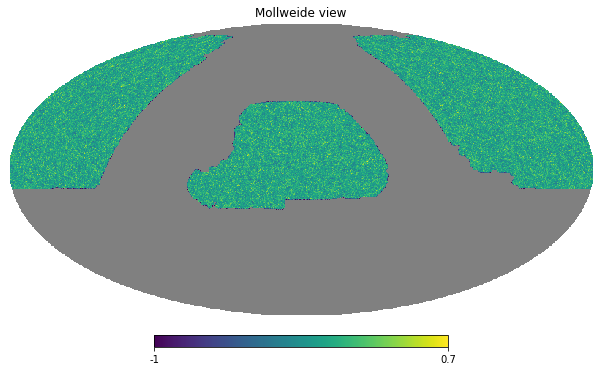

In [39]:
hp.mollview(delta_clean, min=-1, max=0.7)

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


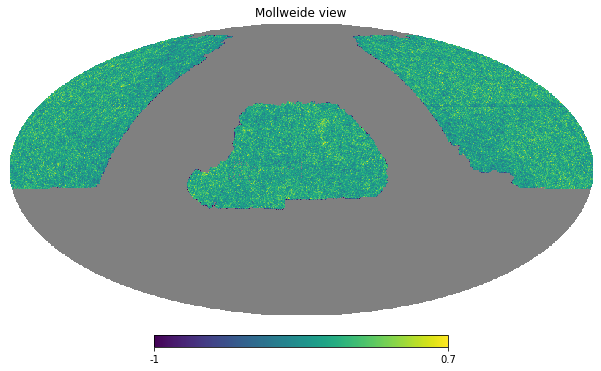

In [40]:
hp.mollview(delta_cont, min=-1, max=0.7)

In [4]:
## read NN models

# read templates
cap = 'N'
templates = ft.read(f'/home/mehdi/github/dr9/results/dr9m_elg_{cap}.fits')
metrics = np.load(f'/home/mehdi/github/dr9/results/regression/elg/{cap}/nn_all_256/metrics.npz', 
                  allow_pickle=True)
stats = metrics['stats'].item()

In [5]:
#--- partition 0
partition = 0
img_data = ImagingData(templates, stats[partition])
dataloader = DataLoader(MyDataSet(img_data.x, img_data.y, img_data.p, img_data.w),
                         batch_size=4098,
                         shuffle=True,
                         num_workers=0)

In [6]:
# --- loss 
Loss, loss_kw = init_loss('mse')  
loss_fn = Loss(**loss_kw)

# --- read model
chck = f'/home/mehdi/github/dr9/results/regression/elg/{cap}/nn_all_256/model_0_1586039469/best.pth.tar'
model = DNN(4, 20, input_dim=13)
checkpoint = load_checkpoint(chck, model)

result = evaluate(model, loss_fn, dataloader, {'device':'cpu'}, return_ypred=True)


loss_p, hpix_p, ngal_p = result
hpix_p = hpix_p.numpy()
ngal_p = ngal_p.numpy().flatten()

In [7]:
npred = np.zeros(12*256*256)
npred[hpix_p] = ngal_p
mask_0 = npred > 0

In [8]:
mask = mask_0 & mask_hp

In [18]:
delta_cont = np.zeros_like(delta_clean)
ratio = 1./np.mean(npred[mask]) #np.std(delta_clean[mask]) / np.std(delta_clean[mask] * npred[mask]) # normalize std of delta
delta_cont[mask] = delta_clean[mask] * npred[mask] * ratio

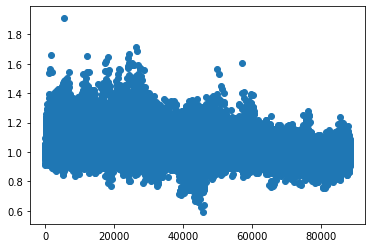

In [19]:
plt.scatter(np.arange(mask.sum()), delta_clean[mask]/delta_cont[mask])

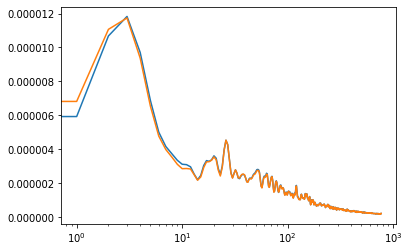

In [24]:
for ni, resi in results.items():
    plt.plot(resi['cl'], label='ni')
    
plt.xscale('log')
# plt.xlim(xmin=10)
# plt.ylim(1.0e-7, 1.0e-4)

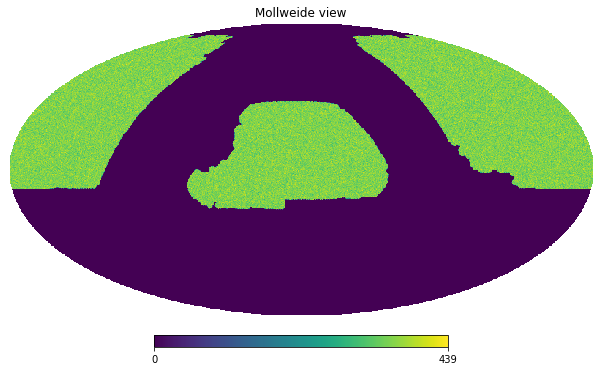

In [61]:
hp.mollview(random_hp)

In [62]:
hp.mollview(mock)

KeyboardInterrupt: 

In [45]:
mask = mask_0 & mask_1

In [50]:
ratio = np.std(delta[mask]) / np.std(delta[mask] * npred1024[mask]) # normalize std of delta
delta_c = delta[mask] * npred1024[mask] * ratio

In [52]:
from lssutils.utils import hpix2radec

In [53]:
ra, dec = hpix2radec(1024, np.argwhere(mask).flatten())

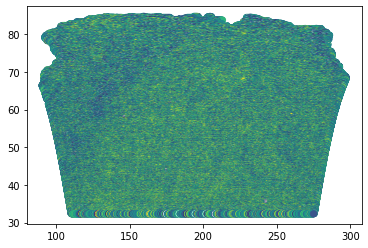

In [54]:
plt.scatter(ra, dec, c=delta[mask], vmin=-1., vmax=1.0)

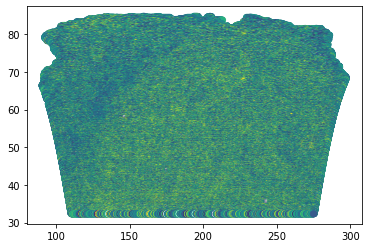

In [56]:
plt.scatter(ra, dec, c=delta_c, vmin=-1., vmax=1.0)

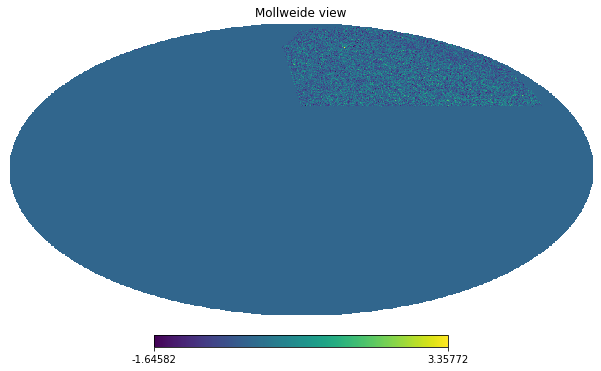

In [49]:
hp.mollview(delta_c*ratio, rot=-85)

In [ ]:
sf = (ngal/npred[hpix]).sum()/ngal.sum()
wnn = npred[hpix]*sf

In [8]:
ls /home/mehdi/github/dr9/results/regression/

elg/  lrg/  qso/


In [2]:
gal = np.load('/home/mehdi/data/tanveer/elg_gal1024.npy')
ran = np.load('/home/mehdi/data/tanveer/elg_ran1024.npy')
delta = np.load('/home/mehdi/data/tanveer/elg_delta1024.npy')
mask = ran > 0.0

In [3]:
def mollview(*x, **kw):
    hp.mollview(*x, **kw, rot=-89)

In [5]:
delta_mr = make_overdensity(gal, ran, mask)

In [6]:
delta_mr[mask] - delta[mask]

array([-0.40419525,  0.74236506, -0.9347877 , ..., -0.00128003,
        0.25549296, -0.32330352], dtype=float32)

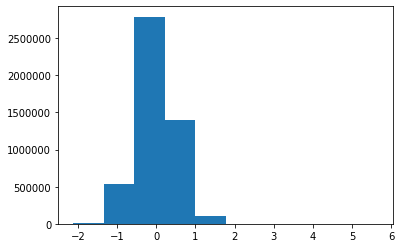

In [7]:
_ = plt.hist(delta[mask])

ModuleNotFoundError: No module named 'torch'

In [33]:
# read templates
cap = 'N'
templates = ft.read(f'/home/mehdi/github/dr9/results/dr9m_elg_{cap}.fits')

In [24]:
metrics = np.load(f'/home/mehdi/github/dr9/results/regression/elg/{cap}/nn_all_256/metrics.npz', 
                  allow_pickle=True)
stats = metrics['stats'].item()

In [41]:
# --- read model
chck = f'/home/mehdi/github/dr9/results/regression//{cap}/nn_all_256/model_0_2664485226/best.pth.tar'
model = DNN(4, 20, input_dim=13)
checkpoint = load_checkpoint(chck, model)

NameError: name 'DNN' is not defined

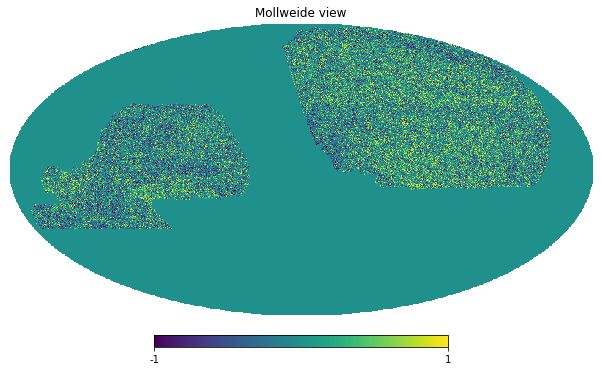

In [41]:
hp.mollview(delta, rot=-85, min=-1, max=1)

In [6]:
af = AnaFast()

In [7]:
result = af(delta, ran, mask)

In [12]:
result

{'l': array([   0,    1,    2, ..., 3069, 3070, 3071]),
 'cl': array([2.15177625e-02, 4.52082369e-03, 1.07930280e-03, ...,
        2.25630021e-07, 2.23888825e-07, 2.38899266e-07]),
 'cl_error': nan,
 'njack': 0,
 'lmax': 3072}

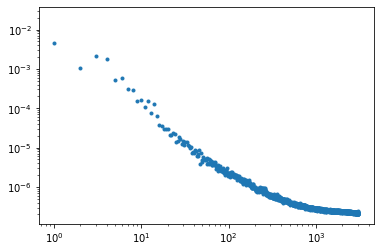

In [11]:
plt.loglog(result['cl'], marker='.', ls='None')

In [4]:
gal

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)